# Importing Necessary Libraries:
For our project, we made heavy use of the sklearn library. We stored all of the necessary imports in this first section.

In [111]:
import pandas as pd
import numpy as np

import time

from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.datasets import make_blobs, make_moons, load_iris, load_digits
from sklearn.cluster import *
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import homogeneity_score, homogeneity_completeness_v_measure
from sklearn.preprocessing import scale
from collections import Counter

import statsmodels.api as sm
import statsmodels.formula.api as smf

import hdbscan
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('seaborn')

# Verifying Integrity of Numerical Columns, and The Conversion of Non-Numerical Columns:
Before any analysis or clustering was done with our data, and before any questions were asked we needed to verify that our data was clean and ready to use. We thought this was the case during the first milestone, but ran into a few problems.

The location of schools should needed to be considered when doing any type of analysis. In order to incorporate the location of these schools into our methods, we converted the State and City columns to numerical values. These values have no weight, but identify the locations in point-space to examine them during clustering. For example, a state like Utah may be converted to a value like 13, where all other occurances of Utah would also be converted to 13. The same process was applied for cities.

Another issue we ran into during our clustering was that the data had not been sufficiently cleaned. We ran into two major issues. The first being the existence of a non-varying feature which would break scaling algorithms due to 0 variance. The second issue we faced was there were quite a few private schools with NaN information, as they were not collected or reported to the government when gathering the data. 

To resolve these problems we did the following:
1. We removed any columns that had no variance as these columns made very little difference to any analysis.
2. We imputed any NaN values with the feature's median value to avoid any outliers, but also to allow us to process the data for most of the schools. We had considered dropping these schools, but we would have lost about half of the dataset. Most of these schools had a majority of their information, but only a few NaN features.

We also checked for any features that were non-numeric, which was not an issue as the data had been cleaned before.

In [113]:
school_data = pd.read_csv('data_files/BASE_clean_college_score_card_data.csv', index_col=0)

# Changing categorical data values to numerical. Here we are mapping states to digits 0-58 (As they
# include more than just the 50 typical states, like BC and Puerto Rico)

# The same is being done for the cities, where they will mapped from 0-2k
state_index_list = []
for i, state in enumerate(set(school_data['STABBR'])):
    state_index = (state, i)
    state_index_list.append(state_index)
    
state_dictionary = dict(state_index_list)
state_dictionary

city_index_list = []
for i, city in enumerate(set(school_data['CITY'])):
    city_index = (city, i)
    city_index_list.append(city_index)
    
city_dictionary = dict(city_index_list)
city_dictionary

school_data.replace({'CITY': city_dictionary, 'STABBR': state_dictionary}, inplace=True)

# Removing the name of the school, as we will not be considering this during clustering.
numeric_school_data = school_data.iloc[:,1:]

#------------------------------------------------------------------------------
# This next section will impute the data, and verify the integrity of the data.
#------------------------------------------------------------------------------

# Resolving any NaN values using Imputation
# Credit to O.rka at https://stackoverflow.com/questions/33660836/impute-entire-dataframe-all-columns-using-scikit-learn-sklearn-without-itera
# For this short process.
fill_NaN = SimpleImputer(missing_values=np.nan, strategy='median')
imputed_DF = pd.DataFrame(fill_NaN.fit_transform(numeric_school_data))
imputed_DF.columns = numeric_school_data.columns
imputed_DF.index = numeric_school_data.index


def verify_data(dataframe):
    '''Check the validity of the data, and verifies it is ready for processing
       variables:
       dataframe - The dataframe of the data looking to be processed.
    '''
    # Check for incorrect column types
    for i in range(len(dataframe.dtypes)):
        if dataframe.dtypes[i] != dataframe.dtypes[1]:
            print(dataframe.dtypes[i])

    print("No other bad dtypes.")

    # Check for NaN values
    if dataframe.isnull().values.any() == True:
        print(np.where(np.isnan(dataframe)))
    
    print("No other NaN values.")

    # Checking each value for infinite values
    for i in range(len(dataframe.columns)):
        for j in range(len(dataframe.index)):
            if np.isfinite(dataframe.iloc[j,i]) == False:
                print(j,i)
                print(dataframe.iloc[j,i])

    print("No other non-finite values.")
    
    # Checking each feature for 0 variance
    for col in dataframe.columns:
        if len(dataframe[col].unique()) == 1:
            print("WARNING:", col, "has only 1 unique value (0 variance) and may cause issues when scaling")
    print("No other 0 variance columns found.")
    
verify_data(imputed_DF)
print("\n")
# Not sure why curroper remained in our data after it was removed, removing it again.
imputed_DF = imputed_DF.drop(columns=['CURROPER'])
verify_data(imputed_DF)

scaled_imputed_df = pd.DataFrame(scale(imputed_DF))
scaled_imputed_df.columns = imputed_DF.columns

# Looking at the new scaled imputed dataframe
scaled_imputed_df
        

No other bad dtypes.
No other NaN values.
No other non-finite values.
No other 0 variance columns found.


No other bad dtypes.
No other NaN values.
No other non-finite values.
No other 0 variance columns found.


CITY    STABBR      HCM2   PREDDEG   HIGHDEG   CONTROL    LOCALE  \
0     0.821608  0.123305 -0.098265  1.081687  1.299137 -1.313341 -0.850394   
1    -0.837301  0.123305 -0.098265  1.081687  1.299137 -1.313341 -0.850394   
2    -0.346092  0.123305 -0.098265  1.081687  1.299137 -0.120011 -0.850394   
3    -0.169429  0.123305 -0.098265  1.081687  1.299137 -1.313341 -0.850394   
4    -0.346092  0.123305 -0.098265  1.081687  1.299137 -1.313341 -0.850394   
5    -1.643057  0.123305 -0.098265  1.081687  1.299137 -1.313341 -0.743004   
6    -0.943586  0.123305 -0.098265  0.129233 -0.199152 -1.313341  1.297416   
7    -1.396016  0.123305 -0.098265  1.081687  0.549992 -1.313341  1.190026   
8    -0.346092  0.123305 -0.098265  1.081687  1.299137 -1.313341 -0.850394   
9     1.207969  0.123305 -0.098265  1.081687  1.299137 -1.313341 -0.743004   
10   -0.837301  0.123305 -0.098265  1.081687  0.549992 -0.120011 -0.850394   
11   -0.604623  0.123305 -0.098265  0.129233 -0.199152 -1.313341  2.263931   
12   -0.346092  0.123305 -0.098265  1.081687  1.299137  1.073319 -0.850394   
13   -0.067452  0.123305 -0.098265  0.129233 -0.199152 -1.313341  1.297416   
14    0.109211  0.123305 -0.098265  0.129233 -0.199152 -1.313341  1.297416   
15   -0.346092  0.123305 -0.098265  1.081687  1.299137 -0.120011 -0.850394   
16    1.301327  0.123305 -0.098265 -0.823221 -0.199152 -1.313341 -0.743004   
17    0.805809  0.123305 -0.098265 -0.823221 -0.948297  1.073319  1.297416   
18   -0.534245  0.123305 -0.098265  0.129233 -0.199152 -1.313341 -0.743004   
19   -1.526718  0.123305 -0.098265  0.129233 -0.199152 -1.313341  1.297416   
20   -1.536772  0.123305 -0.098265  0.129233 -0.199152 -1.313341  1.297416   
21   -0.837301  0.123305 -0.098265 -0.823221  1.299137  1.073319  0.116120   
22   -0.346092  0.123305 -0.098265  1.081687  0.549992 -0.120011 -0.850394   
23   -1.220789  0.123305 -0.098265  1.081687  1.299137 -0.120011 -0.743004   
24   -0.169429  0.123305 -0.098265 -0.823221 -0.199152 -1.313341 -0.850394   
25   -1.207863  0.123305 -0.098265 -0.823221 -0.948297 -1.313341  0.116120   
26   -1.588478  0.123305 -0.098265  1.081687  1.299137 -1.313341 -0.743004   
27   -0.377690  0.123305 -0.098265  0.129233 -0.199152 -1.313341  1.297416   
28   -0.837301  0.123305 -0.098265  0.129233 -0.199152 -1.313341 -0.850394   
29    0.140809  0.123305 -0.098265  0.129233 -0.199152 -1.313341  2.263931   
...        ...       ...       ...       ...       ...       ...       ...   
6662  0.264329  0.684171 -0.098265 -1.775675 -1.697442  1.073319  0.116120   
6663 -1.388835  0.684171 -0.098265 -1.775675 -1.697442  1.073319  0.116120   
6664 -0.394925  0.684171 -0.098265 -1.775675 -1.697442  1.073319  0.116120   
6665 -0.539990  0.684171 -0.098265 -1.775675 -1.697442  1.073319  0.116120   
6666  0.005798  0.684171 -0.098265 -1.775675 -1.697442  1.073319  0.116120   
6667  1.256803  1.058081 -0.098265 -1.775675 -1.697442  1.073319  0.116120   
6668  0.741176  1.058081 -0.098265 -1.775675 -1.697442  1.073319  0.116120   
6669  1.113174  0.621853 -0.098265 -1.775675 -1.697442  1.073319  0.116120   
6670 -1.091524  0.621853 -0.098265 -1.775675 -1.697442  1.073319  0.116120   
6671 -1.283986  0.621853 -0.098265 -1.775675 -1.697442  1.073319  0.116120   
6672  0.509934  0.621853 -0.098265 -1.775675 -1.697442  1.073319  0.116120   
6673  0.491263  0.621853 -0.098265 -1.775675 -1.697442  1.073319  0.116120   
6674  0.679416  0.621853 -0.098265 -1.775675 -1.697442  1.073319  0.116120   
6675 -1.398889  0.310260 -0.098265 -1.775675 -1.697442  1.073319  0.116120   
6676 -1.697636  1.618947 -0.098265 -1.775675 -1.697442 -0.120011  0.116120   
6677 -1.107323 -0.001332 -0.098265 -1.775675 -1.697442 -0.120011  0.116120   
6678  0.343325  1.681266 -0.098265 -1.775675 -1.697442 -0.120011  0.116120   
6679  1.288401  0.434897 -0.098265 -1.775675 -1.697442 -0.120011  0.116120   
6680 -1.091524  0.621853 -0.098265 -1.775675 -1.697442 -0.120011  0.116120   
6681 -1.058489 -0.562197 -0.0982

# The Benefits of Going to College.

Our initial question for this project was the benefit of tuition. We had three main things we wanted to analyze. 
1. Is tuition worth it? Does paying more in tuition increase the income you will expect to receive?
2. What schools are most cost effective?
3. How would schools be clustered together based off of different features?

We begin with our first question.

## 1. Is Tuition Worth It?
In highschool, it is often the case that they will show the earnings after receiving varying levels of education. This includes the expected earnings with only a high-school diploma, an associates degree, a bachelors degree, and so on. We wanted to see specifically, how much more can you make with how you much you <b>spend</b>? This question is not often asked amongst students, rather the question focuses on which degree you study, and where you study. To expand on the latter, we divide these into three categories of school along with an example of each.
1. Public Schools (University of Utah)
2. Private Non-Profit Schools (Brigham Young University)
3. Private For-Profit Schools (Eagle Gate College)

We created a scatterplot of the data to look for any interesting characteristics.

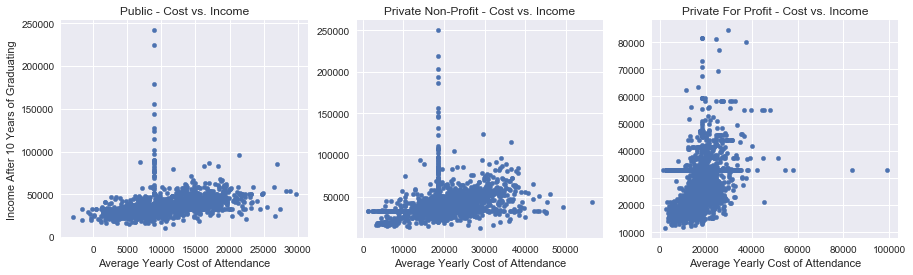

In [131]:
fig, ax = plt.subplots(ncols=3, figsize=(15,4))

public_schools = imputed_DF[imputed_DF['CONTROL'] == 1]            # 0
private_np_schools = imputed_DF[imputed_DF['CONTROL'] == 2]        # 1
private_fp_schools = imputed_DF[imputed_DF['CONTROL'] == 3]        # 2

public_schools.plot.scatter(x='NPT4_PUB', y='MD_EARN_WNE_P10', ax=ax[0])
private_np_schools.plot.scatter(x='NPT4_PRIV', y='MD_EARN_WNE_P10', ax=ax[1])
private_fp_schools.plot.scatter(x='NPT4_PRIV', y='MD_EARN_WNE_P10', ax=ax[2]);

ax[0].title.set_text('Public - Cost vs. Income')
ax[0].set_xlabel('Average Yearly Cost of Attendance')
ax[0].set_ylabel('Income After 10 Years of Graduating')

ax[1].title.set_text('Private Non-Profit - Cost vs. Income')
ax[1].set_xlabel('Average Yearly Cost of Attendance')
ax[1].set_ylabel('')

ax[2].title.set_text('Private For Profit - Cost vs. Income')
ax[2].set_xlabel('Average Yearly Cost of Attendance')
ax[2].set_ylabel('')

plt.show()

We can see something strange happens for a specific price point, namely around 10,000 and 20,000 (for public, and private non-profit respectively). We will revist these groups later. For now, let us examine the general case for schools, and look for centroids to see  what to expect when paying for school, and what to expect for potential earnings.

In [168]:
# Removing outliers for general analysis
public_schools     = imputed_DF[(imputed_DF['CONTROL'] == 1) & (imputed_DF['MD_EARN_WNE_P10'] < 100000)] # 0
private_np_schools = imputed_DF[(imputed_DF['CONTROL'] == 2) & (imputed_DF['MD_EARN_WNE_P10'] < 100000)] # 1
private_fp_schools = imputed_DF[(imputed_DF['CONTROL'] == 3) & 
                                (imputed_DF['MD_EARN_WNE_P10'] < 100000) &
                                (imputed_DF['NPT4_PRIV'] < 60000)] # 2

# Finding centroids:
x_pub = list(public_schools['MD_EARN_WNE_P10'])
y_pub = list(public_schools['NPT4_PUB'])
centroid_pub = (sum(x_pub) / len(list(public_schools['MD_EARN_WNE_P10'])), 
                sum(y_pub) / len(list(public_schools['NPT4_PUB'])))

x_priv_np = list(private_np_schools['MD_EARN_WNE_P10'])
y_priv_np = list(private_np_schools['NPT4_PRIV'])
centroid_priv_np = (sum(x_priv_np) / len(list(private_np_schools['MD_EARN_WNE_P10'])), 
                    sum(y_priv_np) / len(list(private_np_schools['NPT4_PUB'])))

x_priv_fp = list(private_fp_schools['MD_EARN_WNE_P10'])
y_priv_fp = list(private_fp_schools['NPT4_PRIV'])
centroid_priv_fp = (sum(x_priv_fp) / len(list(private_fp_schools['MD_EARN_WNE_P10'])), 
                    sum(y_priv_fp) / len(list(private_fp_schools['NPT4_PUB'])))

print(centroid_pub, centroid_priv_np, centroid_priv_fp)

(35204.85770363101, 9765.474484789009) (39998.11023622047, 20367.303937007873) (29538.925680647535, 17446.67476085357)


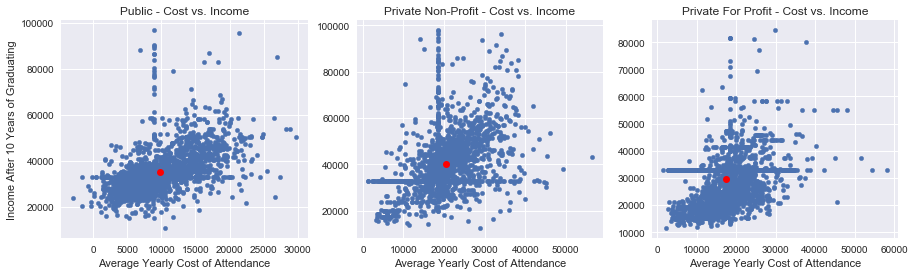

In [166]:
fig, ax = plt.subplots(ncols=3, figsize=(15,4))

public_schools.plot.scatter(x='NPT4_PUB', y='MD_EARN_WNE_P10', ax=ax[0])
private_np_schools.plot.scatter(x='NPT4_PRIV', y='MD_EARN_WNE_P10', ax=ax[1])
private_fp_schools.plot.scatter(x='NPT4_PRIV', y='MD_EARN_WNE_P10', ax=ax[2]);

# plt.point.plot(x=centroid_pub[1], y=centroid_pub[0], ax=ax[0], style='bx', label='point')
ax[0].plot(centroid_pub[1], centroid_pub[0], 'ro') 
ax[0].title.set_text('Public - Cost vs. Income')
ax[0].set_xlabel('Average Yearly Cost of Attendance')
ax[0].set_ylabel('Income After 10 Years of Graduating')

ax[1].plot(centroid_priv_np[1], centroid_priv_np[0], 'ro') 
ax[1].title.set_text('Private Non-Profit - Cost vs. Income')
ax[1].set_xlabel('Average Yearly Cost of Attendance')
ax[1].set_ylabel('')

ax[2].plot(centroid_priv_fp[1], centroid_priv_fp[0], 'ro') 
ax[2].title.set_text('Private For Profit - Cost vs. Income')
ax[2].set_xlabel('Average Yearly Cost of Attendance')
ax[2].set_ylabel('')

plt.show()

Here we can see expected for example, that the expected cost of going to a public school is \\$9765.47 per year, and the expected income is \\$35204.86 10 years after graduation.

We created a few regression models to see how much tuition affected the potential earnings after graduation in general.

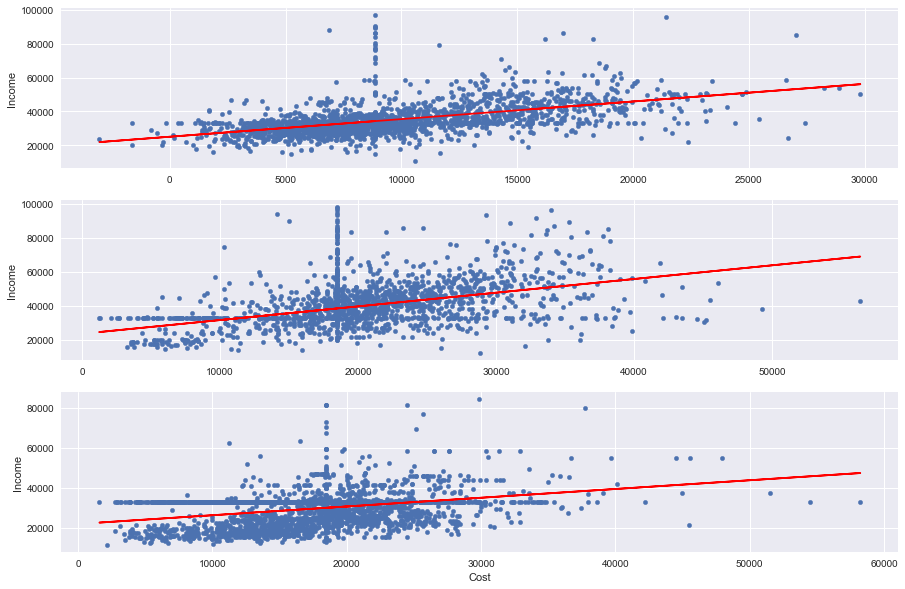

In [169]:
# Public School Regression Model
public_ols = smf.ols(formula="MD_EARN_WNE_P10 ~ NPT4_PUB", 
                     data=public_schools).fit()
pub_predictions = public_ols.predict()

# Private Non-Profit School Regression Model
private_np_ols = smf.ols(formula="MD_EARN_WNE_P10 ~ NPT4_PRIV", 
                     data=private_np_schools).fit()
priv_np_prections = private_np_ols.predict()

# Private Non-Profit School Regression Model
private_fp_ols = smf.ols(formula="MD_EARN_WNE_P10 ~ NPT4_PRIV", 
                     data=private_fp_schools).fit()
priv_fp_prections = private_fp_ols.predict()

# Graphing
fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(15,10)) 

public_schools.plot.scatter(x='NPT4_PUB', y='MD_EARN_WNE_P10', ax=ax[0])
ax[0].plot(public_schools['NPT4_PUB'], pub_predictions, color='red')
ax[0].set_xlabel('')
ax[0].set_ylabel('Income')

private_np_schools.plot.scatter(x='NPT4_PRIV', y='MD_EARN_WNE_P10', ax=ax[1])
ax[1].plot(private_np_schools['NPT4_PRIV'], priv_np_prections, color='red')
ax[1].set_xlabel('')
ax[1].set_ylabel('Income')

private_fp_schools.plot.scatter(x='NPT4_PRIV', y='MD_EARN_WNE_P10', ax=ax[2])
ax[2].plot(private_fp_schools['NPT4_PRIV'], priv_fp_prections, color='red')
ax[2].set_xlabel('Cost')
ax[2].set_ylabel('Income');

These models do in fact show somewhat of a postivie correlation with tuition. While the data varies heavily, it does seem to indicate that, especially with public schools, the more you pay in tuition, the more you will make after school. These effects are much less pronounced in private schools, and vary wildly. This may be caused by the different restrictions that public schools must adhere to, especially when reporting as a Title IV insitution (schools that process <b>federal</b> financial aid).

With these models we can see how much of the variance is explained by looking at the $R^2$ value, and see what the coeffecients are for these functions. This may give us an idea how much more (per dollar spent) you could make in income after 10 years.

In [172]:
print("Overview for each regression model:\n===================================")

print("Public Schools:\n-----------------------------------")
print("R Squared Value:", public_ols.rsquared)
print("With function paramters:\n", public_ols.params, sep="")

print("\n")

print("Private Non-Profit Schools:\n-----------------------------------")
print("R Squared Value:", private_np_ols.rsquared)
print("With function paramters:\n", private_np_ols.params, sep="")

print("\n")

print("Private For-Profit Schools:\n-----------------------------------")
print("R Squared Value:", private_fp_ols.rsquared)
print("With function paramters:\n", private_fp_ols.params, sep="")


Overview for each regression model:
Public Schools:
-----------------------------------
R Squared Value: 0.2641026853576184
With function paramters:
Intercept    25035.512356
NPT4_PUB         1.041357
dtype: float64


Private Non-Profit Schools:
-----------------------------------
R Squared Value: 0.18838413380296004
With function paramters:
Intercept    23623.048604
NPT4_PRIV        0.803988
dtype: float64


Private For-Profit Schools:
-----------------------------------
R Squared Value: 0.09340134417341595
With function paramters:
Intercept    21895.468406
NPT4_PRIV        0.438104
dtype: float64


Revisiting the outliers. We suspsect that this strange spike in those values is due to imputation of the data, let us examine more closely to verify this.

In [238]:
print(imputed_DF[(imputed_DF['CONTROL'] == 1) & 
     (imputed_DF['MD_EARN_WNE_P10'] > 100000)][['NPT4_PUB','MD_EARN_WNE_P10']])

print()

outliers = school_data[(imputed_DF['CONTROL'] == 1) & 
                               (imputed_DF['MD_EARN_WNE_P10'] > 100000)]['INSTNM']

school_data_outliers = school_data
school_data_outliers = school_data_outliers.set_index('INSTNM').reindex()
school_data_outliers.loc[outliers, ['NPT4_PUB', 'MD_EARN_WNE_P10']]

      NPT4_PUB  MD_EARN_WNE_P10
215     8860.0         114700.0
239     8860.0         143700.0
1595    8860.0         179000.0
2461    8860.0         127900.0
2878    8860.0         241900.0
3582    8860.0         102100.0
3596    8860.0         155100.0
3686    8860.0         124600.0
3859    8860.0         224300.0



NPT4_PUB  MD_EARN_WNE_P10
INSTNM                                                                       
University of California-Hastings College of Law         NaN         114700.0
University of California-San Francisco                   NaN         143700.0
University of Massachusetts Medical School Worc...       NaN         179000.0
SUNY Downstate Medical Center                            NaN         127900.0
Oklahoma State University Center for Health Sci...       NaN         241900.0
University of Texas Southwestern Medical Center          NaN         102100.0
University of North Texas Health Science Center          NaN         155100.0
Eastern Virginia Medical School                          NaN         124600.0
West Virginia School of Osteopathic Medicine             NaN         224300.0

It appears that the assumption was correct. The data may not have been reported as these schools most likely have separate medical schools within them that report differently, or they are private schools that chose not to. The specific reason as to why these schools did not report there yearly costs is unknown. Unfortunately we can rely on all of the imputed data, but for clustering purposes this should cause too much of a skew.

# 2. What Schools Are Most Cost Effective?
We can also do a basic analysis of the percentage change in yearly cost and yearly salary. This only uses one year for each, as scalars should not affect this calculation. For this we are going to use the formula $$\frac{S - T}{T}\cdot 100$$
where $S$ is the salary 10 years after graduation (for one year) and $T$ is the cost of attendance (for one year). This is just a general ranking of these schools, but can provide some insight as to which schools should be looked at first when looking for which school to attend.

As an example, let us compare the University of Utah to BYU. This will give us the following:

In [269]:
uofu = school_data[school_data['INSTNM'] == "University of Utah"][['NPT4_PUB', 'MD_EARN_WNE_P10']].values
t_1 = uofu[0][0]
s_1 = uofu[0][1]
print(t_1, s_1)
print((s_1 - t_1) / (t_1))

byu = school_data[school_data['INSTNM'] == "Brigham Young University-Provo"][['NPT4_PRIV', 'MD_EARN_WNE_P10']].values
t_2 = byu[0][0]
s_2 = byu[0][1]
print(t_2, s_2)
print((s_2 - t_2) / (t_2))


12674.0 53000.0
3.1817894902950923
12795.0 59700.0
3.6658851113716295


In this case BYU would "outrank" UofU because the cost of tuition is less, but you are expected to make more. We will now create a new dataframe with this information to take a quick look. We will also be removing any schools that do not report their information instead of imputing them, as it makes no sense for this situation.

In [305]:
import warnings


def rank_schools(df):
    '''Ranks schools based off of the formula above'''
    warnings.filterwarnings('ignore')
    
    # Break schools into public and private, and remove any schools with no info
    public_df  = df[df['NPT4_PUB'].notnull() & df['MD_EARN_WNE_P10'].notnull()]
    private_df = df[df['NPT4_PRIV'].notnull() & df['MD_EARN_WNE_P10'].notnull()]
    
    ratio_list = []
    for i in range(len(public_df)):
        t_1 = public_df.iloc[i, public_df.columns.get_loc('NPT4_PUB')]
        s_1 = public_df.iloc[i, public_df.columns.get_loc('MD_EARN_WNE_P10')]
        ratio_list.append((s_1 - t_1) / (t_1))
        
    public_df['COST_EFC'] = ratio_list
    
    # Reset ratio list, and do the same for private schools
    ratio_list = []
    for i in range(len(private_df)):
        t_1 = private_df.iloc[i, private_df.columns.get_loc('NPT4_PRIV')]
        s_1 = private_df.iloc[i, private_df.columns.get_loc('MD_EARN_WNE_P10')]
        ratio_list.append((s_1 - t_1) / (t_1))
        
    private_df['COST_EFC'] = ratio_list
    
    # Combining and sorting the list by COST_EFC
    combined_df = pd.concat([public_df, private_df])
    combined_df = combined_df.sort_values(by=['COST_EFC'], ascending=False)
    warnings.filterwarnings('default')
    return combined_df

In [310]:
ranked_schools = rank_schools(school_data)
ranked_schools.head(10)[['INSTNM', 'NPT4_PUB', 'NPT4_PRIV', 'MD_EARN_WNE_P10', 'COST_EFC']]

INSTNM  NPT4_PUB  NPT4_PRIV  \
3636           Ogden-Weber Technical College     139.0        NaN   
2525             Cleveland Community College     168.0        NaN   
801                 Albany Technical College     702.0        NaN   
4301         Gordon Cooper Technology Center    1227.0        NaN   
327                        Grossmont College    1353.0        NaN   
466                     College of San Mateo    1688.0        NaN   
484                          Skyline College    1705.0        NaN   
4366            Seattle Vocational Institute    1430.0        NaN   
3969       Colegio Universitario de San Juan    1173.0        NaN   
11    Chattahoochee Valley Community College    1392.0        NaN   

      MD_EARN_WNE_P10    COST_EFC  
3636          26000.0  186.050360  
2525          24500.0  144.833333  
801           21700.0   29.911681  
4301          34900.0   27.443358  
327           34000.0   24.129342  
466           40700.0   23.111374  
484           40500.0   22.753666  
4366          32300.0   21.587413  
3969          24400.0   19.801364  
11            28900.0   19.761494

We can see that the most cost effective school does not necessarily mean the best school to go to, as some of the salary does not warrant four to six years of attending the school. What about the schools where the salary is good?

In [315]:
ranked_schools[ranked_schools['MD_EARN_WNE_P10'] > 50000].head(10)[['INSTNM', 'NPT4_PUB', 'NPT4_PRIV', 'MD_EARN_WNE_P10', 'COST_EFC']]

INSTNM  NPT4_PUB  NPT4_PRIV  \
2480        United States Merchant Marine Academy    6866.0        NaN   
2273                CUNY Bernard M Baruch College    7193.0        NaN   
2149                         Princeton University       NaN    10256.0   
4875           University of Connecticut-Stamford    8383.0        NaN   
839   Georgia Institute of Technology-Main Campus   11639.0        NaN   
4873   University of Connecticut-Waterbury Campus    8600.0        NaN   
4026                          Stanford University       NaN    14155.0   
4336       University of Washington-Tacoma Campus    8829.0        NaN   
1575                           Harvard University       NaN    14981.0   
3340  Baptist Memorial College of Health Sciences       NaN     9592.0   

      MD_EARN_WNE_P10   COST_EFC  
2480          88100.0  11.831343  
2273          57200.0   6.952176  
2149          74700.0   6.283541  
4875          58400.0   5.966480  
839           79100.0   5.796117  
4873          58400.0   5.790698  
4026          94000.0   5.640763  
4336          57700.0   5.535281  
1575          89700.0   4.987584  
3340          57000.0   4.942452

These results are more of what is expected.

# Creating PCA Model and Showing Variances:

The first 20 components explain 58.386% of the variance in this data.
(0.9009065195715455, 63)

These are the principle components that explain more tha 1% of variance
[0.16805876031913428, 0.07793916938345608, 0.049890792652243825, 0.041064751613734136, 0.024979745235420167, 0.023671366027702107, 0.021670284767720142, 0.020765776873705174, 0.018263485722233602, 0.017283539940596275, 0.016218119244726253, 0.014257744708597928, 0.013180267141982237, 0.012632313588658559, 0.01204969529457748, 0.011990684116808328, 0.010263327269596225, 0.01011050359313668]


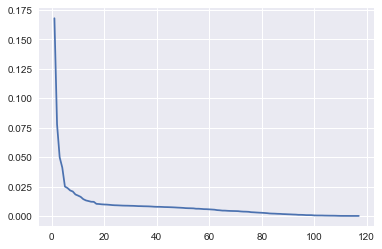

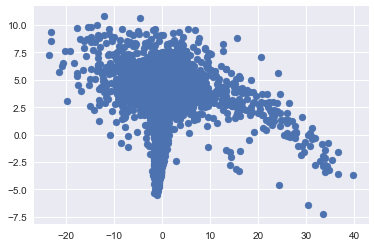

PC0       PC1       PC2       PC3  \
Alabama A & M University            -14.761196  8.874350  3.780629 -0.685040   
University of Alabama at Birmingham   5.367940  4.707486  3.900262 -0.864720   
Amridge University                   -0.755498  0.349884  0.129016  0.254224   
University of Alabama in Huntsville  11.696237  4.211047  6.251628 -0.385960   
Alabama State University            -13.912052  8.406995  3.764582 -1.029000   

                                          PC4       PC5       PC6       PC7  \
Alabama A & M University             4.185767  1.267260  2.065133  1.207074   
University of Alabama at Birmingham  0.039546  3.271173  0.657202 -0.173531   
Amridge University                   4.437594  3.430966 -4.557889 -0.562029   
University of Alabama in Huntsville -0.690747  5.943767  0.154815  0.232202   
Alabama State University             5.506200  0.205088  2.793087  0.962113   

                                          PC8       PC9  ...      PC53  \
Alabama A & M University             2.464418 -3.666358  ... -1.036370   
University of Alabama at Birmingham -0.542162 -1.378490  ... -0.333062   
Amridge University                  -0.880642  2.398155  ... -1.214297   
University of Alabama in Huntsville -1.918800 -1.360917  ... -0.357746   
Alabama State University             4.182398 -3.935242  ...  0.115920   

                                         PC54      PC55      PC56      PC57  \
Alabama A & M University            -0.038658 -1.361671  0.112319 -0.390343   
University of Alabama at Birmingham  0.457409 -0.581440  0.226715 -0.673676   
Amridge University                  -1.475370  0.103213 -0.965670  1.658775   
University of Alabama in Huntsville  0.963833 -0.889569 -1.244289 -0.201485   
Alabama State University            -0.601914  0.362026  2.454019  0.108143   

                                         PC58      PC59      PC60      PC61  \
Alabama A & M University             0.073657 -0.290826 -0.170203 -0.200840   
University of Alabama at Birmingham  0.455129 -0.797175  0.286771  0.636324   
Amridge University                  -0.972324 -0.261562 -0.131517 -0.125538   
University of Alabama in Huntsville  0.739844  0.299132  0.047931 -0.041264   
Alabama State University            -1.534748  2.025180  0.148261  0.040396   

                                         PC62  
Alabama A & M University             1.616926  
University of Alabama at Birmingham -0.320435  
Amridge University                   1.934534  
University of Alabama in Huntsville -0.868886  
Alabama State University             1.533953  

[5 rows x 63 columns]

In [3]:
pca_model = PCA()
snsd_PCA = pca_model.fit_transform(scaled_imputed_df)

def sum_variance_explained(pca_model, pca_component_limit, verbose=True):
    '''Finds the total variance explained within n number of components'''
    sum_of_components = 0
    for i in range(pca_component_limit):
        sum_of_components += pca_model.explained_variance_ratio_[i]
    if verbose == True:
        print("The first ", pca_component_limit, " components explain ", 
              round(sum_of_components*100, 3), "% of the variance in this data.", sep = "")
    return sum_of_components
    
def find_optimal_components(pca_model, tolerance):
    '''Finds the number of componenets needed to provide enough variance within the tolerance amount'''
    limit = 0
    sum_of_components = sum_variance_explained(pca_model, 0, verbose=False)
    while (1.00-sum_of_components > tolerance):
        sum_of_components = sum_variance_explained(pca_model, limit, verbose=False)
        limit += 1
    return sum_of_components, limit

# Examples of the functions defined above
sum_variance_explained(pca_model, 20)
print(find_optimal_components(pca_model, .10))

num_components_needed = find_optimal_components(pca_model, .10)[1]
    
# Plotting the explained variance for each principle component
list_of_PCA_variances = []
for i in range(len(pca_model.explained_variance_ratio_)):
    list_of_PCA_variances.append(pca_model.explained_variance_ratio_[i])
    
print("\nThese are the principle components that explain more tha 1% of variance")
components_to_use = []
for variance in list_of_PCA_variances:
    if variance > 0.01:
        components_to_use.append(variance)
print(components_to_use)

# This shows an extreme drop off for variances, which infers that we do not need a majority of these columns
# for clustering
plt.plot(np.linspace(1, len(pca_model.explained_variance_ratio_), 
                     len(scaled_imputed_df.columns)), list_of_PCA_variances)
plt.show()
plt.scatter(snsd_PCA[:,0],snsd_PCA[:,1])
plt.show()

column_names = []
for i in range(num_components_needed):
    header = "PC"
    component_number = str(i)
    column_names.append(header + component_number)

PCA_DF = pd.DataFrame(snsd_PCA[:,0:len(column_names)], columns=column_names, 
                      index=list(school_data.iloc[:,0]))

# Show the new points in R^n where n=dimensions left after PCA
PCA_DF.head()


# Running the Spectral Clustering Method:
Major problem: My computer cannot run the algorithm on all schools without blowing up, it takes over 2 hours 
with 5000 schools out of the nearly 6000+

In [4]:
# Example spectral clustering models, variables can be changed.
start = time.time()
clustering = SpectralClustering(n_clusters=5, assign_labels="discretize", random_state=0).fit(PCA_DF.iloc[0:500,:])
print("Clusters:", set(clustering.labels_))
end = time.time()
print("\nTime taken: ", end="")
print(end - start)

/home/owen/anaconda3/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Clusters: {0, 1, 2, 3, 4}

Time taken: 11.844664335250854


# Testing KMeans

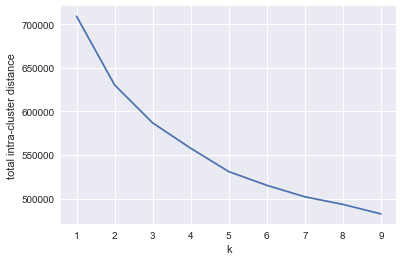

In [5]:
ks = range(1,10)
scores = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit_predict(PCA_DF)
    scores.append(-model.score(PCA_DF))

plt.plot(ks, scores)
plt.ylabel('total intra-cluster distance')
plt.xlabel('k')
plt.show()

Unfortunately, we do not see a very clear drop-off here. The intracluster distance does not have a drop off point, which may indicate that this data is not clustered nicely. We may have some non-concave shapes.

# Testing DBSCAN 

In [6]:
def test_dbscan(eps, min_samples):
    db_model = DBSCAN(eps=eps, min_samples=min_samples)
    db_model.fit(PCA_DF)
    y_pred = db_model.fit_predict(PCA_DF)
    labels = db_model.labels_
    return labels

eps = np.linspace(1,10, 19)
for i in eps:
    current_set = set(test_dbscan(i, 30))
    print(current_set, i)
    if i > 100 and len(current_set) == 1:
        break

{0, -1} 1.0
{0, 1, -1} 1.5
{0, 1, -1} 2.0
{0, 1, 2, -1} 2.5
{0, 1, 2, -1} 3.0
{0, 1, -1} 3.5
{0, -1} 4.0
{0, 1, -1} 4.5
{0, 1, 2, -1} 5.0
{0, 1, 2, -1} 5.5
{0, 1, 2, -1} 6.0
{0, 1, 2, 3, -1} 6.5
{0, 1, 2, 3, -1} 7.0
{0, 1, 2, -1} 7.5
{0, 1, 2, -1} 8.0
{0, 1, -1} 8.5
{0, 1, -1} 9.0
{0, 1, -1} 9.5
{0, 1, -1} 10.0


# Assume the Clusters are Created Correctly

In [7]:
db_model = DBSCAN(eps=7.0, min_samples=30)
db_model.fit(PCA_DF)
y_pred = db_model.fit_predict(PCA_DF)
labels = db_model.labels_
# Run, find cluster, focus on cluster data, cluster again, find nearest cluster, repeat for n<10 schools?

In [8]:
data = PCA_DF

cluster_map = pd.DataFrame()
cluster_map['school'] = data.index.values
cluster_map['cluster'] = labels
# eps = 5.5
# 0 ?
# 1 Technical schools?
# 2 Truck driving, vocational
# 3 Cosmetology schools
# 4 california? something else?
# 5 Argosy
# 6 Jewish
# 7 indiana
# 8 ? 
# 9 beauty school
# 10 university of phoenix
# 11 nursing
# 12 golfing
# 13 recording, productions

# Find average earnings for clusters, locations

current_cluser = cluster_map[cluster_map['cluster'] == 1]
#print(school_data.iloc[current_cluser.index,:].describe()['MD_EARN_WNE_P10'])
#print(school_data.iloc[current_cluser.index,:].describe())
#school_data.iloc[current_cluser.index,:]

# Good cluster, 2.5, 10 high earnings, cluster 1

# Testing with HDBSCAN

In [41]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=30)
cluster_labels = clusterer.fit_predict(PCA_DF)
hdlabels = clusterer.labels_
set(hdlabels)
# Only 2 clusters with my data using 50, 30, what happened? Why do we have different scaling for PCA?
# Changing values to give us more clusters to analyze different possibilities

{-1, 0, 1, 2, 3, 4, 5}

In [42]:
clusterList = list(zip(hdlabels, PCA_DF.index.values))
len(clusterList)

6692

In [43]:
# Removes noise cluster
for i in sorted(clusterList, key=lambda x: x[0]):
    if i[0] < 0:
        clusterList.remove(i)
        
len(clusterList)

3856

In [44]:
sorted_ClusterList = sorted(clusterList, key=lambda x: x[0])

In [45]:
# this cell creates a rotating 3D scatter plot of the top 3 principal components in a pop up window
from matplotlib import interactive
from PyQt5 import QtGui, QtCore
interactive(True)
%matplotlib qt

num_clusters = clusterer.labels_.max()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

color_palette = sns.color_palette('bright', 8)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.9, 0.9, 0.9)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
ax.scatter(PCA_DF.PC1, PCA_DF.PC2, PCA_DF.PC3, linewidth=0, 
                  c=cluster_member_colors, alpha=0.4)


ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title("Hierarchical DBSCAN w/ %d Clusters" % num_clusters)

for angle in range(0, 360):
    ax.view_init(10, angle)
    plt.draw()
    plt.pause(.0001);
# Why does secondary window popup?

<Figure size 432x288 with 0 Axes>

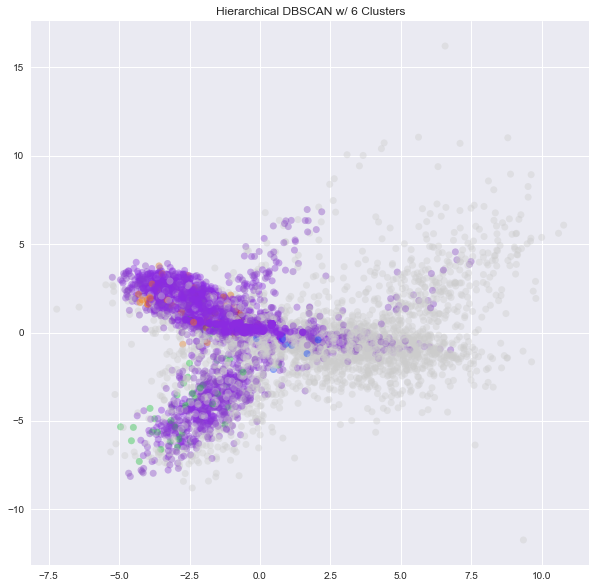

In [46]:
#2D scatter plot of top 2 PC's
# What do the white, orange, and blue spots correspond to?
%matplotlib inline
plt.figure(figsize=(10, 10))

color_palette = sns.color_palette('bright', 8)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.8, 0.8, 0.8)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(PCA_DF.PC1, PCA_DF.PC2,  linewidth=0, c=cluster_member_colors, alpha=0.4)
plt.title("Hierarchical DBSCAN w/ %d Clusters" % (num_clusters + 1))

plt.show;

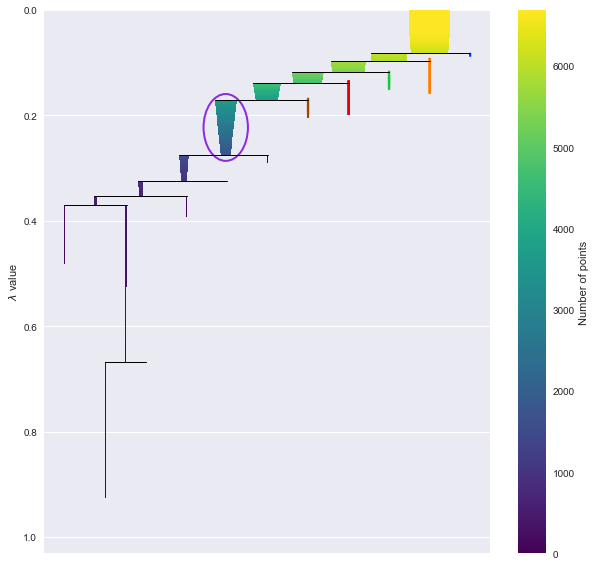

In [47]:
#dendogram of the clusters
# What is being circled? What are we looking at here?
%matplotlib inline
plt.figure(figsize=(10, 10))
clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('bright', 8))

In [53]:
# Changing index datafile used here, to fit Kevin's loops
school_data.index = school_data.iloc[:,0]
school_data = school_data.drop(columns=['INSTNM'])

In [54]:
#create empty lists and dataframes for all the clusters
cluster1 = []
cluster1_df = pd.DataFrame(columns=('CONTROL', 'GRAD_DEBT_MDN_SUPP', 'MD_EARN_WNE_P10'))
cluster2 = []
cluster2_df = pd.DataFrame(columns=('CONTROL', 'GRAD_DEBT_MDN_SUPP', 'MD_EARN_WNE_P10'))
cluster3 = []
cluster3_df = pd.DataFrame(columns=('CONTROL', 'GRAD_DEBT_MDN_SUPP', 'MD_EARN_WNE_P10'))
cluster4 = []
cluster4_df = pd.DataFrame(columns=('CONTROL', 'GRAD_DEBT_MDN_SUPP', 'MD_EARN_WNE_P10'))
cluster5 = []
cluster5_df = pd.DataFrame(columns=('CONTROL', 'GRAD_DEBT_MDN_SUPP', 'MD_EARN_WNE_P10'))
cluster6 = []
cluster6_df = pd.DataFrame(columns=('CONTROL', 'GRAD_DEBT_MDN_SUPP', 'MD_EARN_WNE_P10'))
cluster7 = []
cluster7_df = pd.DataFrame(columns=('CONTROL', 'GRAD_DEBT_MDN_SUPP', 'MD_EARN_WNE_P10'))
cluster8 = []
cluster8_df = pd.DataFrame(columns=('CONTROL', 'GRAD_DEBT_MDN_SUPP', 'MD_EARN_WNE_P10'))

#pull out the index of each cluster (school name)
for i in sorted_ClusterList:
    if i[0] == 0:
        cluster1.append(i[1])
    elif i[0] == 1:
        cluster2.append(i[1])
    elif i[0] == 2:
        cluster3.append(i[1])
    elif i[0] == 3:
        cluster4.append(i[1])
    elif i[0] == 4:
        cluster5.append(i[1])
    elif i[0] == 5:
        cluster6.append(i[1])
    elif i[0] == 6:
        cluster7.append(i[1])
    elif i[0] == 7:
        cluster8.append(i[1])
        
#pull in the desired elements for each school in a cluster and put it in a dataframe
for school in cluster1:
    row = pd.DataFrame(school_data.loc[[school], ['CONTROL', 'GRAD_DEBT_MDN_SUPP', 'MD_EARN_WNE_P10']])
    cluster1_df = cluster1_df.append(row)

for school in cluster2:
    row = pd.DataFrame(school_data.loc[[school], ['CONTROL', 'GRAD_DEBT_MDN_SUPP', 'MD_EARN_WNE_P10']])
    cluster2_df = cluster2_df.append(row)
    
for school in cluster3:
    row = pd.DataFrame(school_data.loc[[school], ['CONTROL', 'GRAD_DEBT_MDN_SUPP', 'MD_EARN_WNE_P10']])
    cluster3_df = cluster3_df.append(row)
    
for school in cluster4:
    row = pd.DataFrame(school_data.loc[[school], ['CONTROL', 'GRAD_DEBT_MDN_SUPP', 'MD_EARN_WNE_P10']])
    cluster4_df = cluster4_df.append(row)
    
for school in cluster5:
    row = pd.DataFrame(school_data.loc[[school], ['CONTROL', 'GRAD_DEBT_MDN_SUPP', 'MD_EARN_WNE_P10']])
    cluster5_df = cluster5_df.append(row)
    
for school in cluster6:
    row = pd.DataFrame(school_data.loc[[school], ['CONTROL', 'GRAD_DEBT_MDN_SUPP', 'MD_EARN_WNE_P10']])
    cluster6_df = cluster6_df.append(row)
    
for school in cluster7:
    row = pd.DataFrame(school_data.loc[[school], ['CONTROL', 'GRAD_DEBT_MDN_SUPP', 'MD_EARN_WNE_P10']])
    cluster7_df = cluster7_df.append(row)
    
for school in cluster8:
    row = pd.DataFrame(school_data.loc[[school], ['CONTROL', 'GRAD_DEBT_MDN_SUPP', 'MD_EARN_WNE_P10']])
    cluster8_df = cluster8_df.append(row)

In [55]:
avg_md_debt = (cluster1_df.GRAD_DEBT_MDN_SUPP.mean(), cluster2_df.GRAD_DEBT_MDN_SUPP.mean(),
              cluster3_df.GRAD_DEBT_MDN_SUPP.mean(),cluster4_df.GRAD_DEBT_MDN_SUPP.mean(),
              cluster5_df.GRAD_DEBT_MDN_SUPP.mean(),cluster6_df.GRAD_DEBT_MDN_SUPP.mean(),
              cluster7_df.GRAD_DEBT_MDN_SUPP.mean(),cluster8_df.GRAD_DEBT_MDN_SUPP.mean())
avg_md_earn = (cluster1_df.MD_EARN_WNE_P10.mean(),cluster2_df.MD_EARN_WNE_P10.mean(),
              cluster3_df.MD_EARN_WNE_P10.mean(),cluster4_df.MD_EARN_WNE_P10.mean(),
              cluster5_df.MD_EARN_WNE_P10.mean(),cluster6_df.MD_EARN_WNE_P10.mean(),
              cluster7_df.MD_EARN_WNE_P10.mean(),cluster8_df.MD_EARN_WNE_P10.mean())

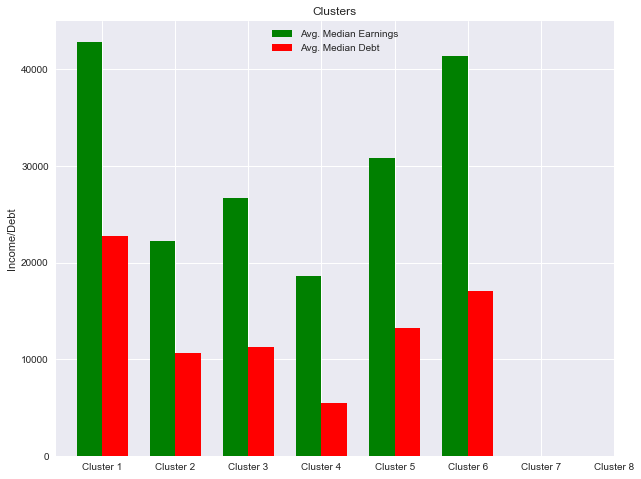

In [56]:
plt.figure(figsize=(10,8))

ind = np.arange(len(avg_md_earn)) 
width = 0.35       
plt.bar(ind, avg_md_earn, width, label='Avg. Median Earnings', color='g')
plt.bar(ind + width, avg_md_debt, width, label='Avg. Median Debt', color='r')

plt.ylabel('Income/Debt')
plt.title('Clusters')

plt.xticks(ind + width / 2, ('Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6',
                            'Cluster 7', 'Cluster 8'))
plt.legend(loc='best')
plt.show()

In [61]:
# Printing out the size of each cluster
print(len(cluster1))
print(len(cluster2))
print(len(cluster3))
print(len(cluster4))
print(len(cluster5))
print(len(cluster6))
# Cluster sizes are very small with my data, only 1 main cluster, not good.

16
45
51
43
3665
36


16475.0
